In [3]:
import numpy as np
from pathlib import Path
import tensorflow as tf
from keras.layers import Input, RandomFlip, RandomContrast, BatchNormalization, RandomTranslation, Flatten, Dropout
from keras.layers import Dense, Conv2D, Activation, MaxPooling2D, GlobalMaxPooling2D, Rescaling
import matplotlib.pyplot as plt
from PIL import Image

# Download Dataset
---

In [51]:

import os
import subprocess
import zipfile

DS_DESTINATION="media/TP1-3-natural-scenes.zip"
DS_UNZIP_DEST=DS_DESTINATION.replace(".zip","")
DS_DRIVE_ID="1Pqs5Y6dZr4R66Dby5hIUIjPZtBI28rmJ"
TRAIN_DIRECTORY = Path("media/TP1-3-natural-scenes/seg_train/seg_train/")
TEST_DIRECTORY = Path("media/TP1-3-natural-scenes/seg_test/seg_test/")

if not os.path.isfile(DS_DESTINATION):
    print(subprocess.run(["gdown", DS_DRIVE_ID, "-O", DS_DESTINATION], 
                        capture_output=True))
    with zipfile.ZipFile(DS_DESTINATION, 'r') as zip_ref:
        zip_ref.extractall(DS_UNZIP_DEST)
    
    for DIR in [TRAIN_DIRECTORY,TEST_DIRECTORY ] :
        path, directories, files = [ (p, d, f) for p,d,f in os.walk(DIR)][0]
        root_path = str(path)
        labels = directories

        for label in labels:
            current_dir = os.path.join(root_path, label)
            print(f"Working on dir {label} on {path}")
            for path, directories, image_files in os.walk(str(current_dir)):
                for image_file in image_files:
                    current_name = os.path.join(current_dir, image_file)
                    new_name = os.path.join(current_dir, label + "_" + image_file)
                    os.rename(current_name, new_name)

In [66]:
BATCH_SIZE = 150
# Tamaño de las imágenes
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

# Carga los datos de entrenamiento y validación
train_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIRECTORY,
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE
    )

val_ds = tf.keras.utils.image_dataset_from_directory(
    TEST_DIRECTORY,
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=123,
    image_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    batch_size=BATCH_SIZE
    )

# Obtiene los nombres de las clases
class_names = train_ds.class_names
num_classes = len(class_names)
class_lens = {}
val_lens = {}


# for img,labels in class_names:
#     train_dir = TRAIN_DIRECTORY.joinpath(c)
#     val_dir = TEST_DIRECTORY.joinpath(c)
#     class_lens[c] = len([name for name in os.listdir(train_dir)])
#     val_lens[c] = len([name for name in os.listdir(val_dir)])

print(f"Train: {class_lens}")
print(f"Test:{val_lens}")



Found 3000 files belonging to 6 classes.
Using 2400 files for training.
Found 3000 files belonging to 6 classes.
Using 600 files for validation.


ValueError: too many values to unpack (expected 2)

In [65]:
vals = np.unique(np.fromiter(val_ds.map(lambda x, y: y), float), return_counts=True)

for val, count in zip(*vals):
    print(int(val), count)

ValueError: setting an array element with a sequence.

tf.Tensor([0. 0. 0. 0. 0. 1.], shape=(6,), dtype=float32)
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([0. 0. 0. 0. 1. 0.], shape=(6,), dtype=float32)
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([0. 0. 0. 0. 1. 0.], shape=(6,), dtype=float32)
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([0. 0. 0. 0. 1. 0.], shape=(6,), dtype=float32)
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([0. 0. 0. 0. 1. 0.], shape=(6,), dtype=float32)
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([1. 0. 0. 0. 0. 0.], shape=(6,), dtype=float32)
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
tf.Tensor([0. 1. 0. 0. 0

<Figure size 1000x1000 with 0 Axes>

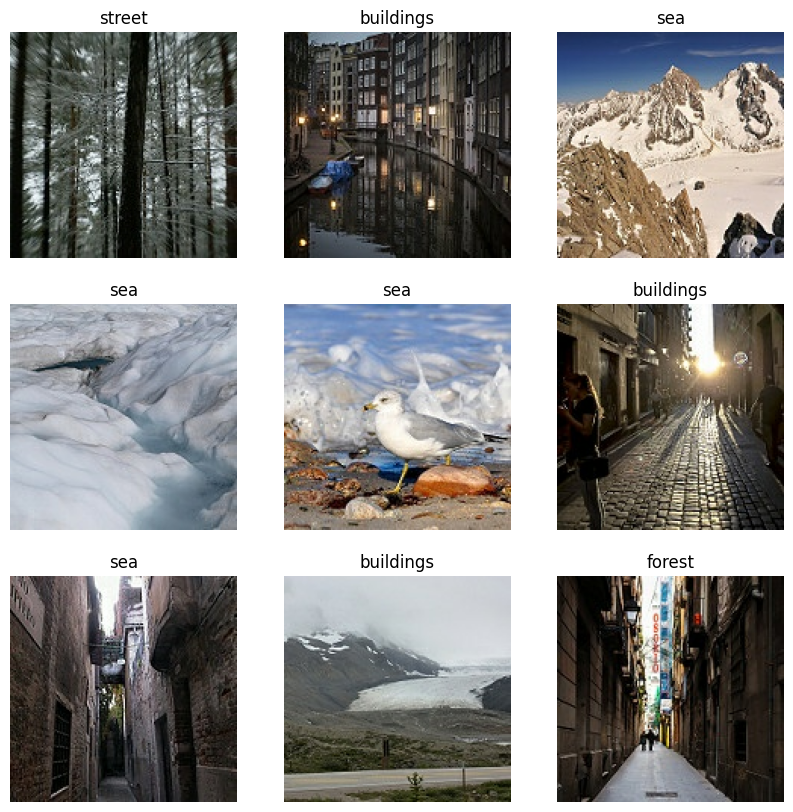

In [61]:
plt.figure(figsize=(10, 10))

for images, labels in val_ds.take(1):
  plt.figure(figsize=(10, 10))
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    print(labels[i])
    print(class_names)
    plt.imshow(images[i].numpy().astype("uint8"))
    class_idx = list(labels[i]).index(1)

    plt.title(class_names[class_idx])
    plt.axis("off")

In [41]:
def build_model(input_shape, output_labels):
    i = Input(input_shape, dtype=tf.float32)

    x = Rescaling(1./255)(i)
    x = RandomFlip("horizontal")(x)
    x = RandomFlip("vertical")(x)
    x = RandomTranslation(0.1, 0.1, fill_mode="reflect")(x)
    x = RandomContrast(0.2)(x)

    x = Conv2D(8, (3, 3))(x)
    x = Activation("relu")(x)

    x = Conv2D(16, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(32, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Conv2D(64, (3, 3))(x)
    x = Activation("relu")(x)

    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(output_labels)(x)
    x = Activation("softmax")(x)
    return tf.keras.Model(inputs=[i], outputs=[x])

In [42]:
print("Building model")
model = build_model((IMAGE_HEIGHT, IMAGE_WIDTH, 3), num_classes)

model.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy'])

Building model


In [43]:
EPOCHS = 3
# Entrena el modelo
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE
)

Epoch 1/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 34s 348ms/step - accuracy: 0.1716 - loss: 1.7937 - val_accuracy: 0.1750 - val_loss: 1.7913
Epoch 2/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 33s 348ms/step - accuracy: 0.1788 - loss: 1.7912 - val_accuracy: 0.1750 - val_loss: 1.7903
Epoch 3/3
94/94 ━━━━━━━━━━━━━━━━━━━━ 30s 323ms/step - accuracy: 0.1789 - loss: 1.7910 - val_accuracy: 0.1750 - val_loss: 1.7903


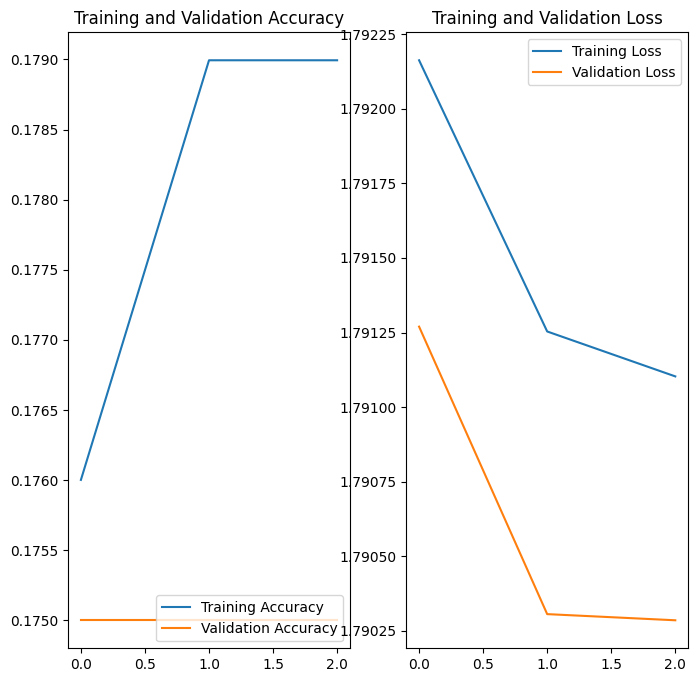

In [44]:
# Grafica la precisión y pérdida de entrenamiento y validación
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
[[0.15809517 0.162506   0.17002203 0.17808807 0.1616538  0.16963488]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[0.15891945 0.16281088 0.16957846 0.17602839 0.16228703 0.17037578]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[0.15757373 0.16253148 0.1706813  0.1785081  0.16138846 0.16931692]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
[[0.1590903  0.16291174 0.16985945 0.17600948 0.16183245 0.1702966 ]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.15828116 0.1626809  0.16953185 0.17710781 0.16222426 0.17017402]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[0.15754896 0.16164556 0.1708005  0.1792917  0.16103803 0.16967519]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
[[0.1586953  0.16304372 0.16931334 0.17621379 0.16294165 0.16979218]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
[[0.15894395 0.16322243 0.16897163 0.17560486 0.16294253 0.17031455]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
[[0.15914856 0.16320084 0.16924363 0.17511378 0.16290818 0.17038499]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

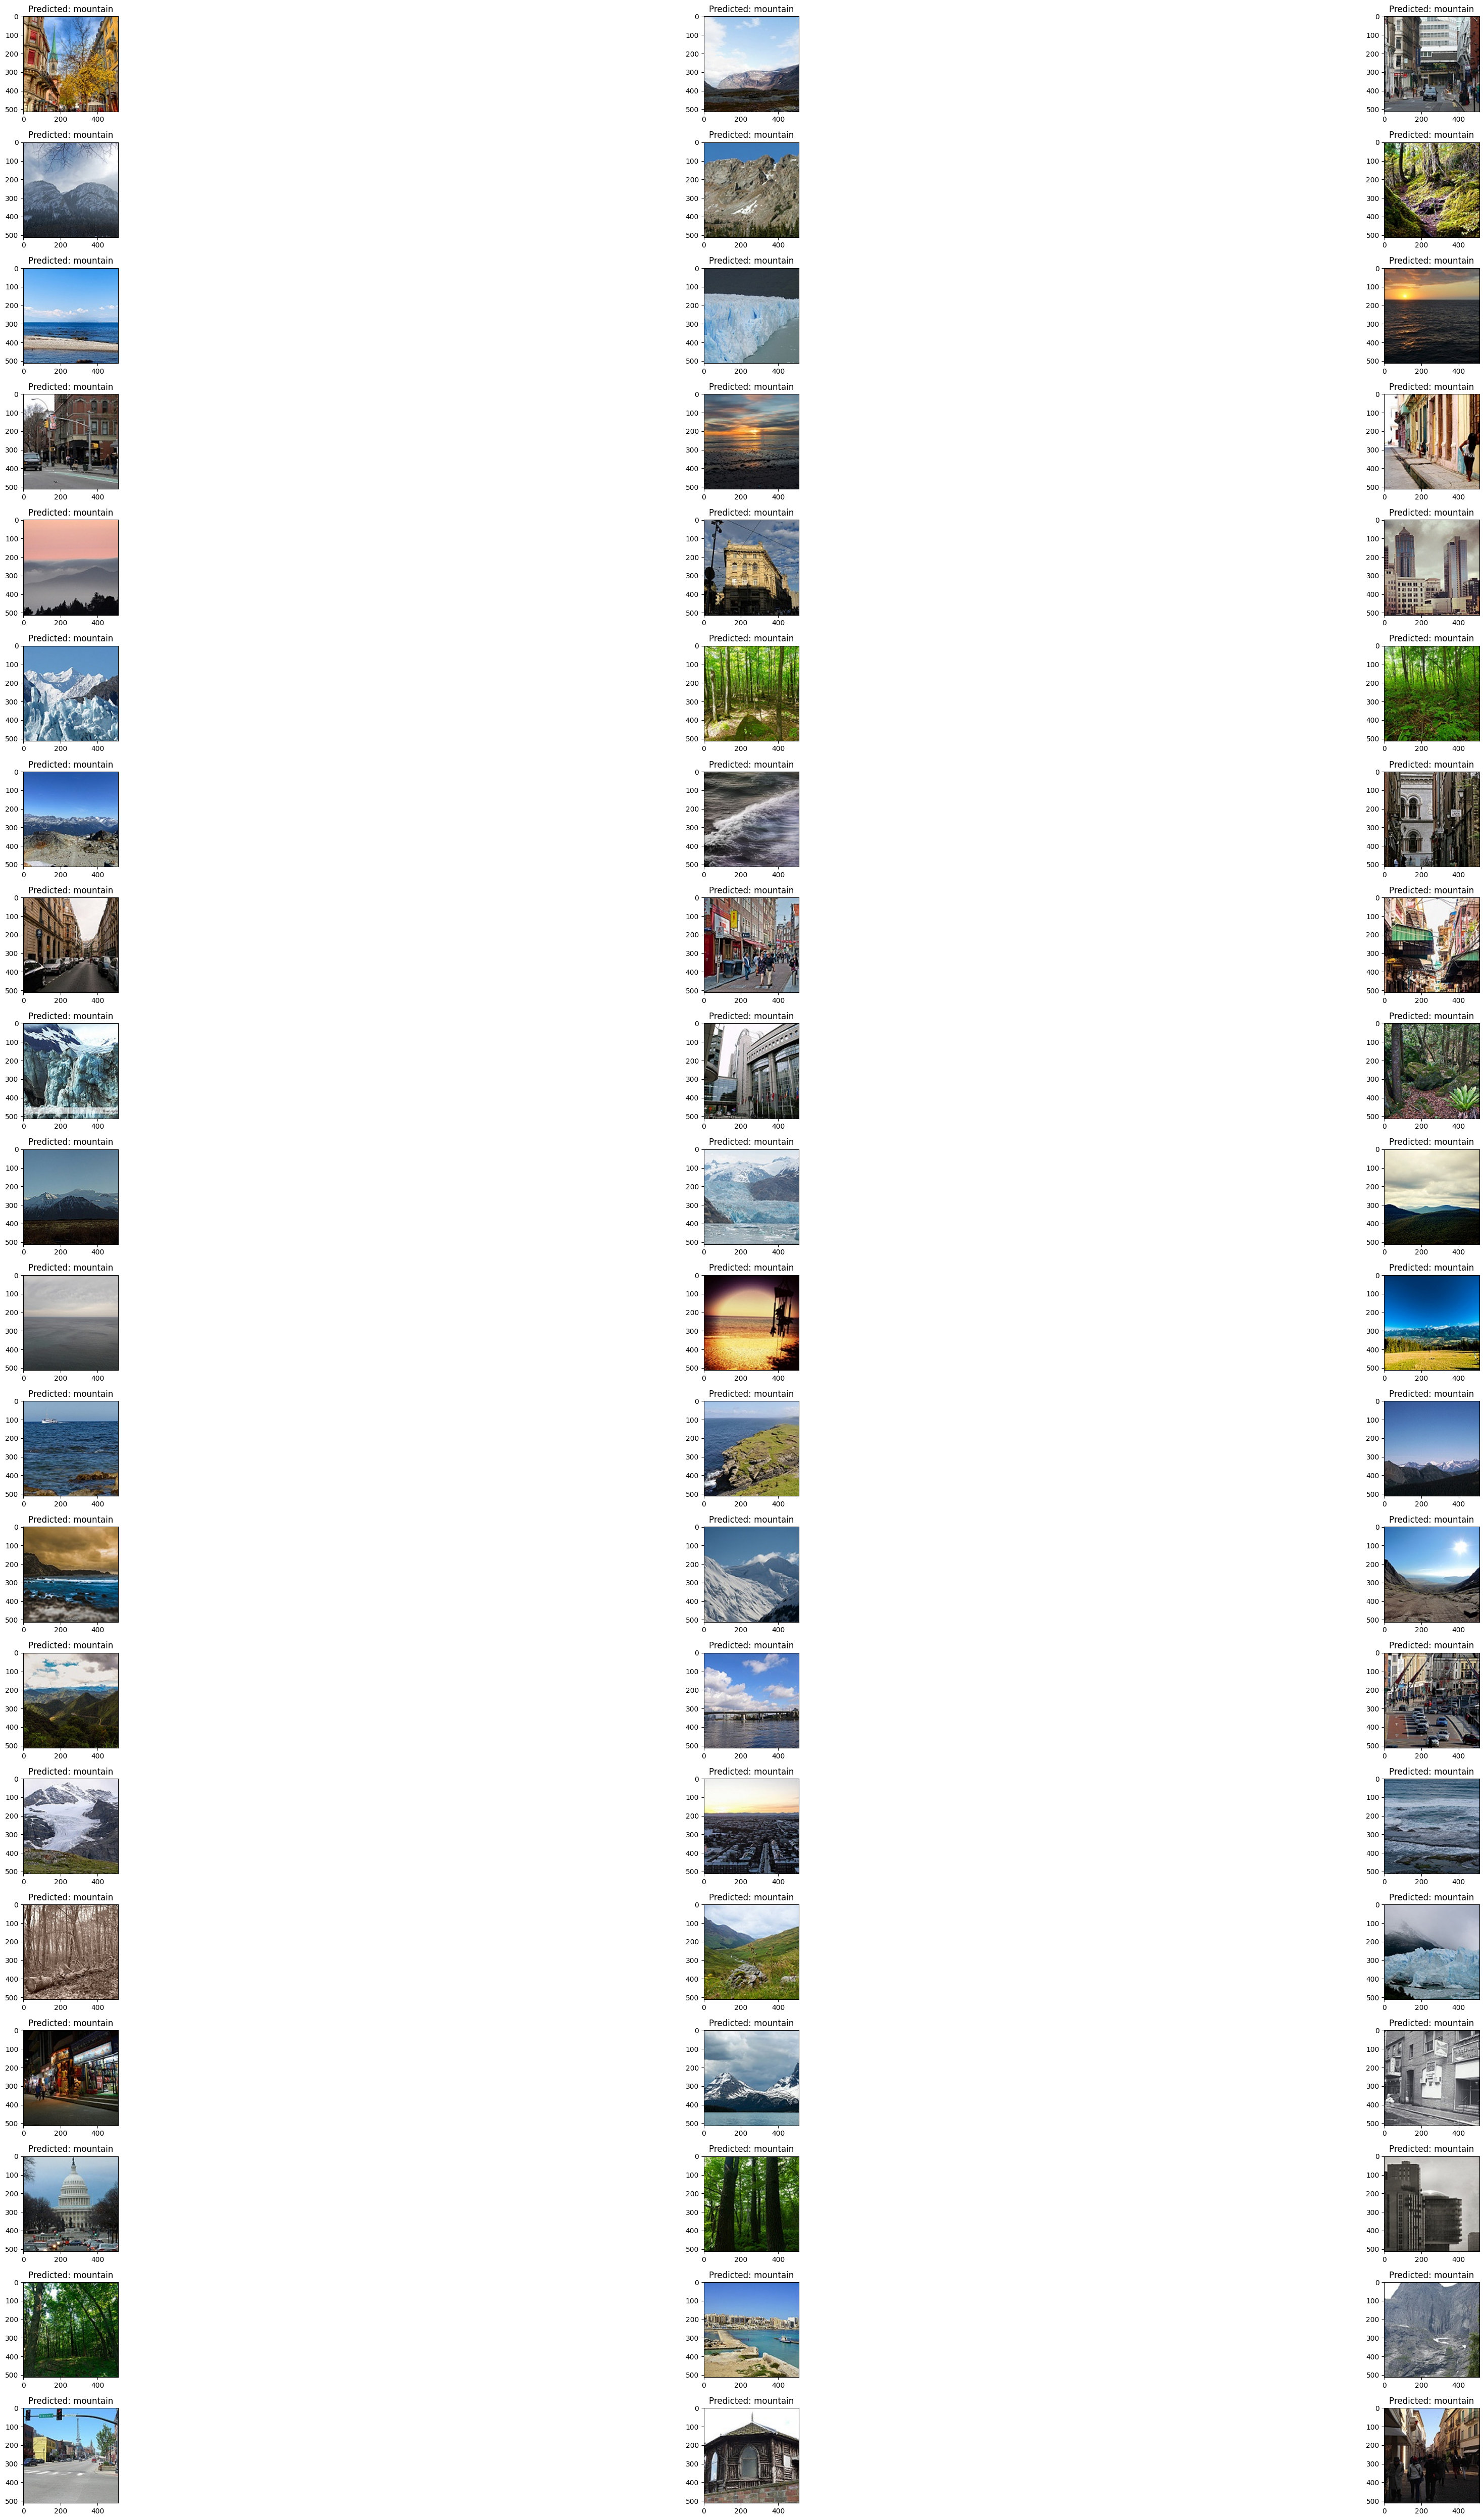

In [45]:
# Function to preprocess the image
def preprocess_image(image_path, target_size=(150, 150)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    return img

# Test images directory
TEST_IMAGES_DIRECTORY = Path("media/TP1-3-natural-scenes/seg_pred/seg_pred/")

# Get list of test image paths
test_image_paths = list(TEST_IMAGES_DIRECTORY.glob("*.jpg"))

# Display 5 images with their actual and predicted classes
sx=20
sy=3
fig, axs = plt.subplots(sx, sy, figsize=(50, 50))

i = 0
for x in range(0, sx):
    for y in range(0,sy):

        image_path = test_image_paths[i]
        image = preprocess_image(image_path)
        image_show = preprocess_image(image_path,(512,512))
        axs[x][y].imshow(image_show)
        image = np.expand_dims(image, axis=0)  # Add batch dimension

        # Perform prediction
        prediction = model.predict(image)
        print(prediction)
        predicted_class_index = np.argmax(prediction)
        predicted_class = class_names[predicted_class_index]        

        axs[x][y].set_title(f"Predicted: {predicted_class}")
        i+=1

plt.tight_layout()
plt.show()